In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

# GPU 확인 코드 (추가)
print("="*50)
print("GPU 호환성 체크")
print("="*50)
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"CUDA 버전: {torch.version.cuda}")
print(f"GPU 개수: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"메모리: {torch.cuda.get_device_properties(i).total_memory // 1024**2} MB")
else:
    print("GPU를 사용할 수 없습니다. CPU 모드로 실행됩니다.")

print(f"현재 디바이스: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print("="*50)

GPU 호환성 체크
PyTorch 버전: 2.8.0+cu129
CUDA 사용 가능: True
CUDA 버전: 12.9
GPU 개수: 1
GPU 0: NVIDIA GeForce RTX 4070 Ti
메모리: 12281 MB
현재 디바이스: cuda


In [11]:
# ==============================================================
# 1. 경로 및 전처리 설정
# ==============================================================

# 데이터셋 루트 경로 설정
data_dir = "C:/blooming_AI/classification_dataset" # 예시 경로입니다. 실제 'dataset' 폴더의 상위 경로로 지정해주세요.
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# torchvision.datasets.ImageFolder를 사용하여 데이터셋 생성
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Train 클래스 정보 저장
class_names = train_dataset.classes
num_classes = len(class_names)
train_class_to_idx = train_dataset.class_to_idx.copy()

# Test 클래스에 OOD 추가 (인덱스 4으로 고정)
test_class_to_idx = train_class_to_idx.copy()
test_class_to_idx['ood'] = 4

# Test 데이터의 실제 라벨을 재매핑
print("\n원본 Test class_to_idx:", test_dataset.class_to_idx)
remapped_samples = []
for path, original_label in test_dataset.samples:
    folder_name = os.path.basename(os.path.dirname(path))
    new_label = test_class_to_idx[folder_name]
    remapped_samples.append((path, new_label))

test_dataset.samples = remapped_samples
test_dataset.imgs = remapped_samples
test_dataset.class_to_idx = test_class_to_idx
print("재매핑된 Test class_to_idx:", test_dataset.class_to_idx)

print(f"\n클래스: {class_names}")
print(f"Train 클래스 매핑: {train_class_to_idx}")
print(f"Test 클래스 매핑: {test_class_to_idx}")
print(f"Train 샘플 수: {len(train_dataset)}")
print(f"Validation 샘플 수: {len(val_dataset)}")
print(f"Test 샘플 수: {len(test_dataset)}")
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


원본 Test class_to_idx: {'diseased': 0, 'downy': 1, 'healthy': 2, 'ood': 3, 'powdery': 4}
재매핑된 Test class_to_idx: {'diseased': 0, 'downy': 1, 'healthy': 2, 'powdery': 3, 'ood': 4}

클래스: ['diseased', 'downy', 'healthy', 'powdery']
Train 클래스 매핑: {'diseased': 0, 'downy': 1, 'healthy': 2, 'powdery': 3}
Test 클래스 매핑: {'diseased': 0, 'downy': 1, 'healthy': 2, 'powdery': 3, 'ood': 4}
Train 샘플 수: 28670
Validation 샘플 수: 5734
Test 샘플 수: 8962


In [4]:
# ==============================================================
# 2. 모델 정의
# ==============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=True)
# 출력층의 뉴런 개수를 데이터셋의 클래스 개수에 맞춰 자동으로 설정
model.classifier[1] = nn.Linear(model.last_channel, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

C:\Users\51100\anaconda3\envs\ultra\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\51100\anaconda3\envs\ultra\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# ======================
# 3. Training Loop
# ======================
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    # --- Train ---
    model.train()
    running_loss, running_corrects = 0.0, 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # --- Validation ---
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val  ]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects.double() / len(val_dataset)
    end_time = time.time()
    epoch_duration = end_time - start_time
    minutes = int(epoch_duration // 60)
    seconds = int(epoch_duration % 60)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
          f"Time: {minutes}m {seconds}s")
    # best 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "mob_ood_nc.pth")

print("Training finished. Best Val Acc:", best_val_acc.item())

Epoch 1/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 180/180 [10:33<00:00,  3.52s/it]


Epoch 1/10 | Train Loss: 0.8229, Acc: 0.9866 | Val Loss: 0.7879, Acc: 0.9993 | Time: 62m 16s


Epoch 2/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 180/180 [10:16<00:00,  3.43s/it]


Epoch 2/10 | Train Loss: 0.7947, Acc: 0.9976 | Val Loss: 0.7831, Acc: 0.9995 | Time: 62m 2s


Epoch 3/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 180/180 [10:16<00:00,  3.42s/it]


Epoch 3/10 | Train Loss: 0.7872, Acc: 0.9990 | Val Loss: 0.7826, Acc: 0.9995 | Time: 62m 24s


Epoch 4/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 180/180 [10:38<00:00,  3.54s/it]


Epoch 4/10 | Train Loss: 0.7849, Acc: 0.9993 | Val Loss: 0.7816, Acc: 0.9998 | Time: 62m 59s


Epoch 5/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 180/180 [10:26<00:00,  3.48s/it]


Epoch 5/10 | Train Loss: 0.7838, Acc: 0.9992 | Val Loss: 0.7815, Acc: 0.9993 | Time: 62m 13s


Epoch 6/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 180/180 [10:35<00:00,  3.53s/it]


Epoch 6/10 | Train Loss: 0.7833, Acc: 0.9992 | Val Loss: 0.7820, Acc: 0.9993 | Time: 63m 11s


Epoch 7/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 180/180 [09:22<00:00,  3.13s/it]


Epoch 7/10 | Train Loss: 0.7829, Acc: 0.9994 | Val Loss: 0.7818, Acc: 0.9993 | Time: 58m 31s


Epoch 8/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 180/180 [09:22<00:00,  3.12s/it]


Epoch 8/10 | Train Loss: 0.7827, Acc: 0.9993 | Val Loss: 0.7862, Acc: 0.9951 | Time: 56m 39s


Epoch 9/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 180/180 [09:21<00:00,  3.12s/it]


Epoch 9/10 | Train Loss: 0.7823, Acc: 0.9995 | Val Loss: 0.7810, Acc: 0.9997 | Time: 56m 38s


Epoch 10/10 [Val  ]: 100%|███████████████████████████████████████████████████████████| 180/180 [09:19<00:00,  3.11s/it]

Epoch 10/10 | Train Loss: 0.7819, Acc: 0.9997 | Val Loss: 0.7814, Acc: 0.9997 | Time: 56m 37s
Training finished. Best Val Acc: 0.999825601674224


In [7]:
# ======================
# 4. 신뢰도 임계값 계산 (Validation Set)
# ======================
print("\n" + "="*50)
print("신뢰도 임계값 계산 중...")
print("="*50)

eval_device = torch.device("cuda")
model.load_state_dict(torch.load("mob_ood_nc.pth", map_location=eval_device))
model.to(eval_device)
model.eval()

val_confidences = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(eval_device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        max_probs, _ = torch.max(probs, dim=1)
        val_confidences.extend(max_probs.cpu().numpy())

# 5 백분위수를 임계값으로 설정
confidence_threshold = np.percentile(val_confidences, 1)
print(f"신뢰도 임계값 (하위 1%): {confidence_threshold:.4f}")
print(f"평균 신뢰도: {np.mean(val_confidences):.4f}")
print(f"최소 신뢰도: {np.min(val_confidences):.4f}")
print(f"최대 신뢰도: {np.max(val_confidences):.4f}")


신뢰도 임계값 계산 중...
신뢰도 임계값 (하위 1%): 0.7422
평균 신뢰도: 0.7728
최소 신뢰도: 0.4310
최대 신뢰도: 0.9164


In [12]:
# ======================
# Test 평가 (OOD 감지)
# ======================
print("\n" + "="*50)
print("Test Set 평가 (OOD 감지 포함)")
print("="*50)

model.eval()

all_preds = []
all_labels = []
all_confidences = []
total_inference_time = 0.0
ood_label_idx = 4

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        start_time = time.time()
        outputs = model(inputs)
        end_time = time.time()
        total_inference_time += (end_time - start_time)

        probs = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        for i in range(len(preds)):
            gt = labels[i].item()
            conf = max_probs[i].item()
            
            if conf < confidence_threshold:
                pred_label = ood_label_idx
            else:
                pred_label = preds[i].cpu().item()
                all_confidences.append(conf)
            
            all_labels.append(gt)
            all_preds.append(pred_label)


Test Set 평가 (OOD 감지 포함)


In [13]:
# ======================
# 결과 요약
# ======================
avg_inference_time = total_inference_time / len(test_dataset)

ood_as_known = sum(1 for gt, pred in zip(all_labels, all_preds)
                   if gt == ood_label_idx and pred != ood_label_idx)

known_as_ood = sum(1 for gt, pred in zip(all_labels, all_preds)
                   if gt != ood_label_idx and pred == ood_label_idx)

print(f"\n[결과 요약]")
print(f"1. Total test images: {len(test_dataset)}")
print(f"2. Average inference time per image: {avg_inference_time:.6f} sec")
print(f"3. GT가 OOD인데 known으로 판단된 수: {ood_as_known}")
print(f"4. GT가 known인데 OOD로 판단된 수: {known_as_ood}")


[결과 요약]
1. Total test images: 8962
2. Average inference time per image: 0.000242 sec
3. GT가 OOD인데 known으로 판단된 수: 286
4. GT가 known인데 OOD로 판단된 수: 61


In [16]:
# ======================
# Classification Report
# ======================
print("\n" + "="*50)
print("Classification Report (5개 클래스)")
print("="*50)

all_class_names = list(class_names) + ['ood']

report = classification_report(
    all_labels, all_preds,
    target_names=all_class_names,
    labels=[0, 1, 2, 3, 4],
    digits=5,
    output_dict=True,
    zero_division=0
)

for cls_name in all_class_names:
    metrics = report.get(cls_name, {})
    print(f"{cls_name:10s} | Precision: {metrics.get('precision', 0):.4f} | "
          f"Recall: {metrics.get('recall', 0):.4f} | "
          f"F1: {metrics.get('f1-score', 0):.4f} | "
          f"Support: {metrics.get('support', 0)}")

print(f"\nAccuracy: {report['accuracy']:.4f}")
print(f"Macro avg - Precision: {report['macro avg']['precision']:.4f}, "
      f"Recall: {report['macro avg']['recall']:.4f}, "
      f"F1: {report['macro avg']['f1-score']:.4f}")
print(f"Weighted avg - Precision: {report['weighted avg']['precision']:.4f}, "
      f"Recall: {report['weighted avg']['recall']:.4f}, "
      f"F1: {report['weighted avg']['f1-score']:.4f}")


Classification Report (5개 클래스)
diseased   | Precision: 0.3916 | Recall: 0.9420 | F1: 0.5532 | Support: 69.0
downy      | Precision: 1.0000 | Recall: 0.9917 | F1: 0.9958 | Support: 1557.0
healthy    | Precision: 0.9856 | Recall: 0.9817 | F1: 0.9836 | Support: 2019.0
powdery    | Precision: 0.9303 | Recall: 0.9967 | F1: 0.9623 | Support: 2090.0
ood        | Precision: 0.9797 | Recall: 0.9114 | F1: 0.9443 | Support: 3227.0

Accuracy: 0.9613
Macro avg - Precision: 0.8574, Recall: 0.9647, F1: 0.8879
Weighted avg - Precision: 0.9685, Recall: 0.9613, F1: 0.9633



Confusion Matrix


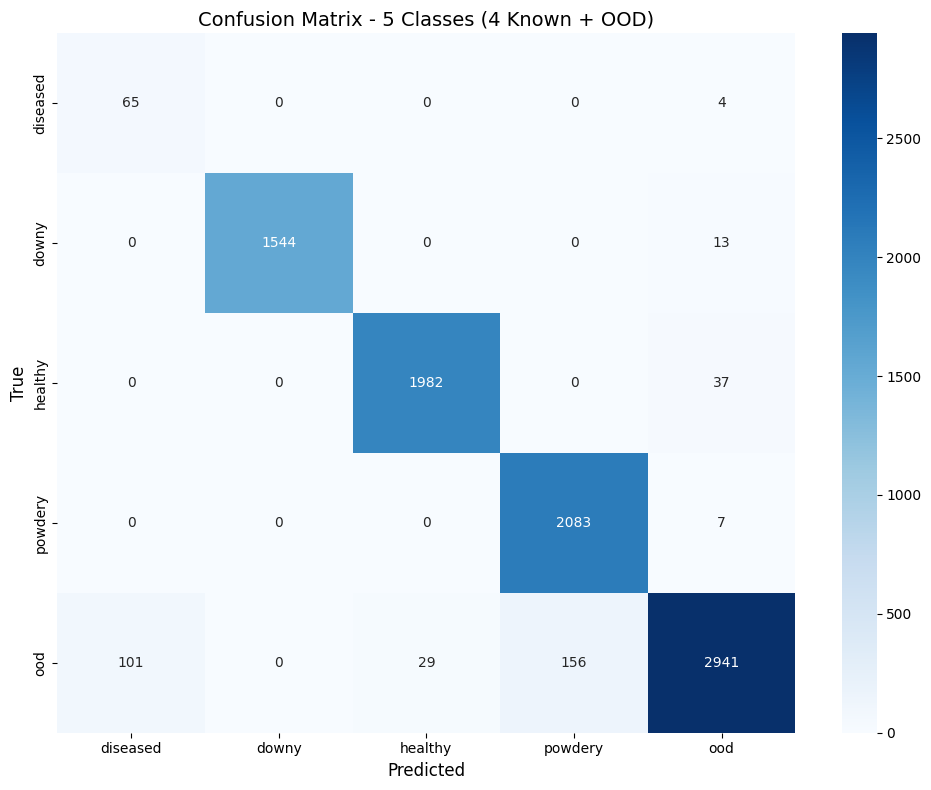

Confusion Matrix 저장 완료: confusion_ood.png


In [15]:
# ======================
# Confusion Matrix
# ======================
print("\n" + "="*50)
print("Confusion Matrix")
print("="*50)

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3, 4])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_class_names, yticklabels=all_class_names)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix - 5 Classes (4 Known + OOD)", fontsize=14)
plt.tight_layout()
plt.savefig("confusion_nocrop_ood.svg")
plt.show()
print("Confusion Matrix 저장 완료: confusion_ood.png")